# IMPORTS

In [ ]:

-The goal of this notebook is to combine and transform Johns Hopkins covid data with weather data from a historic data base (weather.csv attached).

-Another goal is to quickly determine feature importances of a few features using a random forest. This is not supposed to be in-depth.

In [24]:
from matplotlib import pyplot
import pandas as pd
# for plotting
# to divide train and test set
from sklearn.model_selection import train_test_split
# feature scaling
from sklearn.preprocessing import MinMaxScaler
#to buid models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# models for Stacking
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
# to evaluate the model
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,r2_score
import math
#to find training time of the model
import time
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

# IMPORT COVID DATA AND FORMAT

In [25]:
#obtain data form JH github
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
df = pd.read_csv(url, error_bad_lines=False)

#remove unnecessary cols
df = df.drop(columns = ['iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'])
df = df.rename(columns={"Admin2": "County", 'Province_State':'State', 'Long_':'Long'})

#MOST POPULOUS COUNTIES IN U.S. by contintental states only
lyst = []
for x in df['State']:
    df2 = df[(df['State'] == x)]
    df3 = df2[(df2['Population'] == df2['Population'].max())]
    uid = df3.iat[0,0]
    lyst.append(uid)
    
    
df = df[df['UID'].isin(lyst)]
     
#remove states individually
df = df[(df['State'] != 'Hawaii')]
df = df[(df['State'] != 'District of Columbia')]
df = df[(df['State'] != 'Puerto Rico')]
df = df[(df['State'] != 'Alaska')]
df = df[(df['State'] != 'American Samoa')]
df = df[(df['State'] != 'Diamond Princess')]
df = df[(df['State'] != 'Alaska')]
df = df[(df['State'] != 'Northern Mariana Islands')]
df = df[(df['State'] != 'Virgin Islands')]
df = df[(df['State'] != 'Guam')]
df = df[(df['State'] != 'Grand Princess')]


df = df.reset_index(drop = True)

# CREATE LOOP TO MODIFY HOW COVID DATA IS DISPLAYED

In [26]:
#create empty df
column_names = ["Date", "Deaths", "County", "State", "Lat", "Long", "Population"]
data = pd.DataFrame(columns = column_names)


#loop
for x in df['UID']:
    df2 = df[(df['UID'] == x)]
    df2 = df2.drop(columns = ['UID'])


    df2 = df2.T
    #reset col names
    df2.columns = range(df2.shape[1])

    df2['County'] = df2.iloc[0,0]
    df2['State'] = df2.iloc[1,0]
    df2['Lat'] = df2.iloc[2,0]
    df2['Long'] = df2.iloc[3,0]
    df2['Population'] = df2.iloc[4,0]
    

    df2 = df2.iloc[5:]

    df2 = df2.reset_index()

    #rename cols
    df2 = df2.rename(columns={"index":"Date", 0:"Deaths"})
    
    df2['New Deaths'] = df2.Deaths.diff().fillna(0)
    
    data = data.append(df2, True)
    
#change to date time
data['Date'] = pd.to_datetime(data.Date)
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
#round to 6dp
data.Lat = data.Lat.round(decimals=6)
data.Long = data.Long.round(decimals=6)

#FIX NEW DEATHS (some preceeding values are greater than the ones that follow)
data['New Deaths']=data['New Deaths'].mask(data['New Deaths'].lt(0),0)

,Date,Deaths,County,State,Lat,Long,Population,New Deaths
0,2020-01-22,0,Jefferson,Alabama,33.555547,-86.895063,658573,0.0
1,2020-01-23,0,Jefferson,Alabama,33.555547,-86.895063,658573,0.0
2,2020-01-24,0,Jefferson,Alabama,33.555547,-86.895063,658573,0.0
3,2020-01-25,0,Jefferson,Alabama,33.555547,-86.895063,658573,0.0
4,2020-01-26,0,Jefferson,Alabama,33.555547,-86.895063,658573,0.0
...,...,...,...,...,...,...,...,...
37195,2022-03-02,278,Laramie,Wyoming,41.307025,-104.688750,99500,0.0
37196,2022-03-03,278,Laramie,Wyoming,41.307025,-104.688750,99500,0.0
37197,2022-03-04,278,Laramie,Wyoming,41.307025,-104.688750,99500,0.0
37198,2022-03-05,278,Laramie,Wyoming,41.307025,-104.688750,99500,0.0


# WEATHER DATA

In [27]:
# weather----------------------------
#import
dfweather = pd.read_csv("weather.csv")


#rename
dfweather = dfweather.rename(columns={"datetime":"Date"})

#split
dfsplit = dfweather['name'].str.split(',', expand=True)

#drop name from
dfweather = dfweather.drop(columns = ['name'])


#rename split
dfsplit = dfsplit.rename(columns={0:"Lat", 1:"Long"})


#CONCAT
dfw = pd.concat([dfsplit, dfweather], axis=1)

#convert date
dfw['Date'] = pd.to_datetime(dfw.Date)
dfw['Date'] = dfw['Date'].dt.strftime('%Y-%m-%d')
dfw['Date']=dfw['Date'].astype(object)

#convert lat, long to floats
dfw['Lat']=dfw['Lat'].astype(float)
dfw['Long']=dfw['Long'].astype(float)


#pcik cols
dfw = dfw[['Lat', 'Long', 'Date', 'temp', 'humidity', 'windspeed']]

#round
dfw.Lat = dfw.Lat.round(decimals=6)
dfw.Long = dfw.Long.round(decimals=6)





,Lat,Long,Date,temp,humidity,windspeed
0,42.486077,-71.390492,2020-03-01,-3.9,46.16,25.3
1,42.486077,-71.390492,2020-03-02,4.1,55.49,27.2
2,42.486077,-71.390492,2020-03-03,12.1,61.61,24.7
3,42.486077,-71.390492,2020-03-04,8.0,49.14,40.6
4,42.486077,-71.390492,2020-03-05,5.5,45.23,30.6
...,...,...,...,...,...,...
35035,40.003385,-75.137927,2022-02-24,0.7,53.20,20.3
35036,40.003385,-75.137927,2022-02-25,2.9,75.00,28.5
35037,40.003385,-75.137927,2022-02-26,0.3,49.80,16.5
35038,40.003385,-75.137927,2022-02-27,3.5,47.10,30.2


In [28]:
#join weather data to covid data

dfnew = pd.merge(data, dfw, on=['Lat', 'Long', 'Date'])

#sort
new_cols = ["Date","County","State","Population","Lat", 'Long', 'temp', 'humidity', 'windspeed', 'New Deaths','Deaths']
dfnew=dfnew[new_cols]
dfnew=dfnew.reindex(columns=new_cols)
dfnew['New Deaths']=dfnew['New Deaths'].astype(int)



#convert date back 
dfnew['Date'] = pd.to_datetime(dfnew.Date)

,Date,County,State,Population,Lat,Long,temp,humidity,windspeed,New Deaths,Deaths
0,2020-03-01,Jefferson,Alabama,658573,33.555547,-86.895063,12.5,44.47,28.8,0,0
1,2020-03-02,Jefferson,Alabama,658573,33.555547,-86.895063,14.4,85.83,19.0,0,0
2,2020-03-03,Jefferson,Alabama,658573,33.555547,-86.895063,18.8,82.40,24.0,0,0
3,2020-03-04,Jefferson,Alabama,658573,33.555547,-86.895063,13.3,90.78,14.5,0,0
4,2020-03-05,Jefferson,Alabama,658573,33.555547,-86.895063,11.1,89.99,19.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
35035,2022-02-24,Laramie,Wyoming,99500,41.307025,-104.688750,-13.2,68.00,26.9,0,273
35036,2022-02-25,Laramie,Wyoming,99500,41.307025,-104.688750,-10.6,65.60,21.5,0,273
35037,2022-02-26,Laramie,Wyoming,99500,41.307025,-104.688750,-6.9,45.00,22.6,0,273
35038,2022-02-27,Laramie,Wyoming,99500,41.307025,-104.688750,2.5,27.10,37.1,0,273


# FEATURE IMPORTANCE

In [29]:
#Feature Importance Training
#drop some cols
dfnew = dfnew.drop(columns = ['Date', 'County', 'State', 'Deaths'])

,Population,Lat,Long,temp,humidity,windspeed,New Deaths
0,658573,33.555547,-86.895063,12.5,44.47,28.8,0
1,658573,33.555547,-86.895063,14.4,85.83,19.0,0
2,658573,33.555547,-86.895063,18.8,82.40,24.0,0
3,658573,33.555547,-86.895063,13.3,90.78,14.5,0
4,658573,33.555547,-86.895063,11.1,89.99,19.4,0
...,...,...,...,...,...,...,...
35035,99500,41.307025,-104.688750,-13.2,68.00,26.9,0
35036,99500,41.307025,-104.688750,-10.6,65.60,21.5,0
35037,99500,41.307025,-104.688750,-6.9,45.00,22.6,0
35038,99500,41.307025,-104.688750,2.5,27.10,37.1,0


In [30]:

#Training & Test set--------------------------------
x = dfnew.drop(columns = ['New Deaths'])
y = dfnew['New Deaths']

# x = x.reset_index(drop=True)
y = y.reset_index(drop=True)

print("Features:", len(dfnew.columns))
print("Records:", len(dfnew))

Features: 7
Records: 35040


In [31]:
#Testing and Training
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 42)
print("Training set:", len(x_train))
print("Test:", len(x_test))

Features: 781
Training set: 24528
Test: 10512


Feature: 0, Score: 0.13194
Feature: 1, Score: 0.03584
Feature: 2, Score: 0.04297
Feature: 3, Score: 0.19746
Feature: 4, Score: 0.36371
Feature: 5, Score: 0.22808


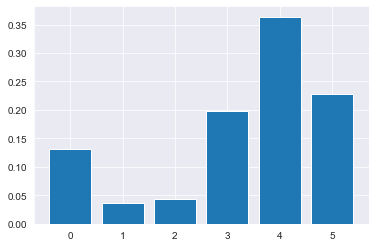

Feature Names: 


,Feature Names,Scores
0,Population,0.131939
1,Lat,0.035837
2,Long,0.042971
3,temp,0.197465
4,humidity,0.363705
5,windspeed,0.228083


In [32]:
#Train the model and display feature importance
model = RandomForestRegressor(n_estimators = 1500, min_samples_split = 2, max_depth = 15,  bootstrap = True,  random_state = 1)

model.fit(x_train, y_train)

scores = []
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    scores.append(v)
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#add features and combine
print("Feature Names: ")
features = []
for col in x:
    features.append(col)
    
dffeats = pd.DataFrame({'Feature Names':features})

dfscores = pd.DataFrame({'Scores':scores})
dffs = pd.concat([dffeats, dfscores], axis=1)
dffs